---
# NOTEBOOK 2 - FEATURE ENGINEERING PART 1:
## Creating and Evaluating New Features
---

# PROJECT : Boston Airbnb Fair Pricing Tool and Recommender

# Feature Enginering Part 1:
From the previous notebook, a few features were ommited from analysis due to their complexity.  They will be evaluated here.

Per the previous notebook:

# Remaining Features
The remaining features which have not yet been investigated are provided as follows, along with a brief plan to evaluate each of those features:
* amenities
    * These need to be separated out into the individual amenities, counted up, and one hot encoded
* description
    * This will require some manual examination and NLP techniques to attempt to find useful features
* host_about
    * This will require some manual examination and NLP techniques to attempt to find useful features
* name
    * This will require some manual examination and NLP techniques to attempt to find useful features
* neighborhood_overview
    * This will require some manual examination and NLP techniques to attempt to find useful features
    
    
## The features below were not able to be explored in this phase of the project and will be explored in subsequent iteration:
* host_location
    * This will need to be combined with host_neighbourhood and encoded accordingly
* host_neighbourhood
    * This will need to be combined with host_location and encoded accordingly
* license
    * This will require come NLP techniques to extract similar values

# 1 - Library Imports, Read Data, and Examine Dataframe

In [1]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For tesxt:
import re

# For times:
import time

# Set a random seed for imputation
#  Source:  https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html
np.random.seed(42)

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# keep the same dataframe name as in the previous notebook
lstn = pd.read_csv('../data/listings_train_2.csv')

In [3]:
lstn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2781 entries, 0 to 2780
Data columns (total 56 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            2781 non-null   int64  
 1   name                                          2781 non-null   object 
 2   description                                   2769 non-null   object 
 3   neighborhood_overview                         1803 non-null   object 
 4   host_id                                       2781 non-null   int64  
 5   host_since                                    2781 non-null   float64
 6   host_location                                 2152 non-null   object 
 7   host_about                                    1977 non-null   object 
 8   host_response_time                            2781 non-null   object 
 9   host_response_rate                            2781 non-null   f

# 2 - Required Functions from Previous Notebook
The functions below have been copied over from the previous notebook as they will be useful here.

In a subsequent phase, these should be added to a .py file.

In [4]:
'''
The col_logger function will need to be brough in from the other notebooks

This has been modified to include a 0 imputation value n such that transforamtion
occurs on log(n) and not log(0) which is undefined.
'''

def col_logger(data_column, zero_imp = 1):
    # Since log(0) is undefined, 0's must be treated as log(1)
    return data_column.apply(lambda x: np.log(zero_imp) if x==0 else np.log(x))

In [5]:
# Create a histogram plotting function:
def hist_plotter(data, title = None, x_lbl = None, y_lbl = 'Count',  size = (6,4), bins = None, log = False):
    plt.figure(figsize = size)
    plt.hist(data, bins = bins, log = log)
    if title == None:
        plt.title(f'{data.name}')
    else:
        plt.title(title)
    if x_lbl == None:
        plt.xlabel(f'{data.name}')
    else:
        plt.xlabel(x_lbl) 
    plt.ylabel(y_lbl)

In [6]:
# Create a function to plot one numerical column versus another
def plot_vs(data_x, data_y, title = None, x_lbl = None, y_lbl = None, size = (6,4), x_log = None, y_log = None):
    plt.figure(figsize = size)
    plt.scatter(data_x, data_y)
    if title == None:
        plt.title(f'{data_y.name} vs. {data_x.name}')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'{data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'{data_y.name}')
    else:
        plt.ylabel(y_lbl)

    if x_log != None:
        plt.xscale(x_log)
        
    if y_log != None:
        plt.yscale(y_log)

In [7]:
# Create a more advanced 'plot vs' function which examines logs too

def plot_vs_log(data_x, data_y, title = None, x_lbl = None, y_lbl = None, size = (15,4), x_log = None, y_log = None):
    
    # calculate the correlations
    #  Source for correlation:  https://www.educative.io/answers/what-is-the-statistics-correlation-method-in-python
    
    # NaNs need to be dropped, in doing that, the array dimensions must match
    #  To do that, indices will be compared to get the intersection of index values
    #  Help with this from:  https://realpython.com/numpy-scipy-pandas-correlation-python/#pearson-correlation-coefficient
    base_corr = round(pd.DataFrame([data_x, data_y]).T.corr().iloc[0][1], 3)
    y_log_corr = round(pd.DataFrame([data_x, col_logger(data_y)]).T.corr().iloc[0][1], 3)
    x_y_log_corr = round(pd.DataFrame([col_logger(data_x), col_logger(data_y)]).T.corr().iloc[0][1], 3)
    
    plt.figure(figsize = size)
    
    # Untransformed variables
    plt.subplot(1, 3, 1)
    plt.scatter(data_x, data_y)
    if title == None:
        plt.title(f'{data_y.name} \nvs. {data_x.name} \ncorr: {base_corr}')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'{data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'{data_y.name}')
    else:
        plt.ylabel(y_lbl)

    # For log scaale, source for help:  https://www.geeksforgeeks.org/how-to-plot-logarithmic-axes-in-matplotlib/
    if x_log != None:
        plt.xscale(x_log)
        
    if y_log != None:
        plt.yscale(y_log)
    
    
    # Log transform y (adjust the axis scale)
    plt.subplot(1, 3, 2)
    plt.scatter(data_x, data_y)
    if title == None:
        plt.title(f'Log {data_y.name} \nvs. {data_x.name}\ncorr: {y_log_corr}')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'{data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'log {data_y.name}')
    else:
        plt.ylabel(y_lbl)

    if x_log != None:
        plt.xscale(x_log)
        
    plt.yscale('log')

    # Log transform BOTH x and y (adjust the axis scales)
    plt.subplot(1, 3, 3)
    plt.scatter(data_x, data_y)
    if title == None:
        plt.title(f'Log {data_y.name} \nvs. Log {data_x.name}\ncorr: {x_y_log_corr}')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'log {data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'log {data_y.name}')
    else:
        plt.ylabel(y_lbl)

    plt.xscale('log')
    plt.yscale('log')

# 3 - Explore and Extract 'amenities'
Amenities are extra items or physical listing features which may entice potential guests.  It's possible that there may be some high-valued amenities (for instance a pool) that would cause a host to charge a higher or lower price.

## 3.1 - Examine the Values

In [8]:
# View the data
lstn.amenities

0       ["Wifi", "Stove", "Kitchen", "Dishwasher", "Fr...
1       ["Wifi", "Carbon monoxide alarm", "Hair dryer"...
2       ["Wifi", "Carbon monoxide alarm", "Hot water",...
3       ["Wifi", "Oven", "Dishwasher", "TV", "Portable...
4       ["Wifi", "Stove", "Window guards", "City skyli...
                              ...                        
2776    ["Wifi", "Stove", "Public or shared beach acce...
2777    ["Wifi", "Stove", "HDTV with Chromecast", "Key...
2778    ["Wifi", "Kitchen", "Iron", "Washer", "Hair dr...
2779    ["Wifi", "AC - split type ductless system", "K...
2780    ["Wifi", "Stove", "Kitchen", "Dishwasher", "Fi...
Name: amenities, Length: 2781, dtype: object

In [9]:
# View the first on in detail
lstn.amenities[0]

'["Wifi", "Stove", "Kitchen", "Dishwasher", "Free street parking", "First aid kit", "Pets allowed", "Toaster", "Coffee maker", "Washer", "Hair dryer", "Central heating", "Blender", "Elevator", "Freezer", "TV", "Bathtub", "Air conditioning", "Bed linens", "Carbon monoxide alarm", "Oven", "Security cameras on property", "Smoke alarm", "Cooking basics", "Dining table", "Free parking on premises", "Baking sheet", "Essentials", "Hot water", "Dishes and silverware", "Clothing storage: walk-in closet and closet", "Fire extinguisher", "Hangers", "Dryer", "Long term stays allowed", "Microwave"]'

In [10]:
# View another
lstn.amenities[100]

'["Wifi", "Oven", "Dishwasher", "TV", "Heating", "Air conditioning", "Microwave"]'

In [11]:
# Check the type
type(lstn.amenities[0])

str

In [12]:
# Find the number of unique amenities
lstn.amenities.nunique()

2212

#### OBSERVATIONS:
* There are many different combinations of amenities
* Individual amenities appear to be part of a smaller list of identical terms
* Each element in this column is actually list stored as a string

These individual terms will need to be extracted and eventually one hot encoded.

## 3.2 - Extract and Encode the Individual Amenities

In [13]:
# Use a regular expression to extract the amenities which are between quotes.
#  Code adapted from this source: https://stackoverflow.com/questions/1454913/regular-expression-to-find-a-string-included-between-two-characters-while-exclud
# Also helpful:  https://regex101.com/
regex_string = '(?<=")[^"]+(?="[,\]])'

amn_lst = []

for string_lists in lstn.amenities:
    
    # Find all amenities for a listing
    a_list = re.findall(regex_string, string_lists)
    
    # Add each amentity into another list
    for amenity in a_list:
        amn_lst.append(amenity)

# Find the total number of unique amenities in the list by reducing to a set
len(set(amn_lst))       

974

In [14]:
# Create a pandas series of all amenities and their number of occurences
amn_counts = pd.Series(amn_lst).value_counts(ascending=False)

# Filter the datafarme to use only words that appear in 99% of posts
#  THIS IS REQUIRED GIVEN THAT min_df IS IGNORED BY COUNT VECTORISZER WITH CUSTOM DICTIONARIES
print(amn_counts[amn_counts >= 35])

#  Create a vocab variable by using the index attribute to get the list of amenities
amn_vocab = amn_counts[amn_counts >= 35].index

Wifi                                        2609
Smoke alarm                                 2563
Carbon monoxide alarm                       2433
Kitchen                                     2388
Essentials                                  2326
                                            ... 
Waterfront                                    40
Private backyard \u2013 Not fully fenced      39
 HDTV with Roku                               37
Beach essentials                              36
Park view                                     36
Length: 143, dtype: int64


In [15]:
# Use countevectorizer to one hot encode all the amenities
#  Use the vocab to get only the amenities encoded
#  NOTE:  Set the 'token_pattern' to the regex string so it finds the exact same tokens as were found previously
cvec = CountVectorizer(lowercase=False,
                       vocabulary=amn_vocab,
                       ngram_range=(1, 1),
                       token_pattern=regex_string
                      )

# Create a new dataframe with the count vectorized data from the amenities column
amen_df = pd.DataFrame(cvec.fit_transform(lstn.amenities).todense(), 
             columns = cvec.get_feature_names_out())

amen_df

,Wifi,Smoke alarm,Carbon monoxide alarm,Kitchen,Essentials,Hangers,Iron,Hair dryer,Heating,Microwave,...,Portable air conditioning,Fireplace guards,Baby bath,Courtyard view,Shared backyard \u2013 Not fully fenced,Waterfront,Private backyard \u2013 Not fully fenced,HDTV with Roku,Beach essentials,Park view
0,1,1,1,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1,1,1,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,1,1,1,1,1,1,0,0,1,1,...,0,1,1,0,0,0,0,0,0,0
2777,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2778,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2779,1,1,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


## 3.3 - Find Ammenity Correlations to Price

In [16]:
# Add the price and log price columns to the new dataframe
amen_df['price__'] = lstn.price
amen_df['log_price__'] = col_logger(lstn.price)
amen_df.shape

(2781, 145)

In [17]:
# Create correaltion matrix between all words and filter for correlations to price

# First ensure there are no NaN values
print(f"Number of NaN values: {amen_df.corr()['price__'].isnull().sum()}")

# Find the correlation corefficients for each of the amenities to the price:
price_amen_corr = amen_df.corr()['price__']
log_price_amen_corr = amen_df.corr()['log_price__']
print(f'\n{price_amen_corr.sort_values(ascending=False)}')
print('='*50)
print(f'\n{log_price_amen_corr.sort_values(ascending=False)}')

Number of NaN values: 0

price__                          1.000000
log_price__                      0.760202
Pack \u2019n play/Travel crib    0.184917
Elevator                         0.166448
Pets allowed                     0.162390
                                   ...   
Paid dryer \u2013 In building   -0.049974
Shared patio or balcony         -0.058238
Private living room             -0.071618
Free street parking             -0.081348
Lock on bedroom door            -0.208319
Name: price__, Length: 145, dtype: float64

log_price__                1.000000
price__                    0.760202
Hair dryer                 0.335156
Pets allowed               0.310873
Elevator                   0.291888
                             ...   
Host greets you           -0.077604
Shared patio or balcony   -0.081407
Private living room       -0.124294
Free street parking       -0.175082
Lock on bedroom door      -0.381361
Name: log_price__, Length: 145, dtype: float64


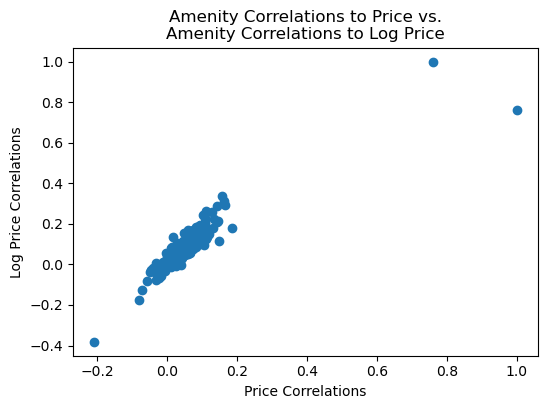

In [18]:
# Check to see if any correlation values are drastically different against price versus log price
plot_vs(price_amen_corr, log_price_amen_corr, 
        title = 'Amenity Correlations to Price vs.\nAmenity Correlations to Log Price',
       x_lbl='Price Correlations', y_lbl='Log Price Correlations')

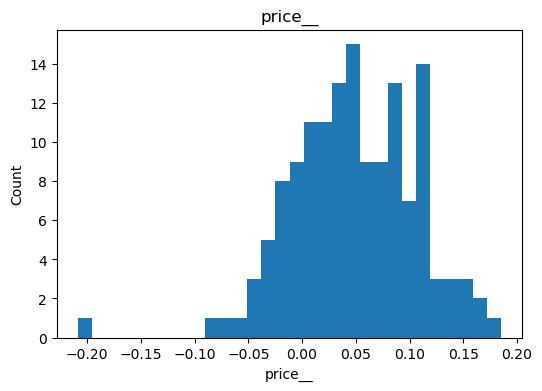

In [19]:
# View the distribution of the correlations (filter out price and log correlations)
hist_plotter(price_amen_corr[price_amen_corr < 0.6], bins = 30)

## 3.4 - Create a Column that Provides the Number of Amenities Provided in Each Listing
Practically speaking, its possible that more amenities means more up-keep for the host and a higher price

In [20]:
# Using regex as before, find the number of amenities for every listing and store to a new column
lstn['amen_cnt'] = lstn.amenities.apply(lambda x: len(re.findall(regex_string, x)))
lstn.amen_cnt

0       36
1       17
2       17
3        5
4       68
        ..
2776    44
2777    39
2778    21
2779    30
2780    34
Name: amen_cnt, Length: 2781, dtype: int64

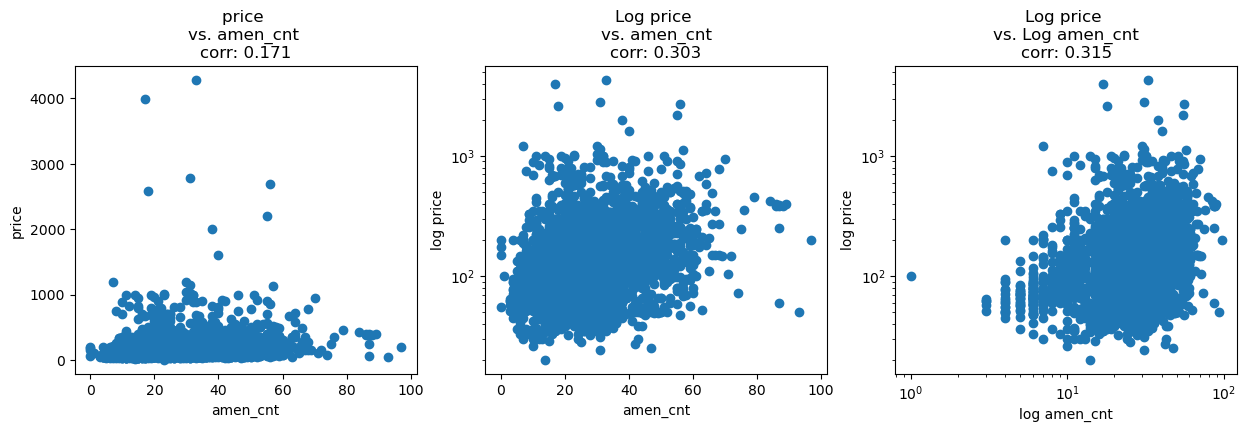

In [21]:
# Plot the price versus amenity count
plot_vs_log(lstn.amen_cnt, lstn.price)

## 3.5 - Amenities Conclusions
* No correlations between any amenity and price or log price exceeds a magnitude of about 0.38 (lock on bedroom door, -0.381)
* Some amenities correlate higher with price and log than others
    * Items like hairdryers and pets being allowed correlate positively with price/log_price
    * Having a 'lock on bedroom door' seems to correlate with a cheaper Airbnb
* The amenity counts do not correlate much higher than even the most highly correlated amenities
* Correlations to the log transformed price are much stronger than those to price, but still relatively weak

# 4 - Descriptive Columns
Name, Description, Neighborhood Overview, and Host About will all now be engineered using NLP tokenization techniques.  This will very efficiently one hot encode the presence of the words used in each of these features.

In [22]:
# Check the data type and first value of each of the columns
for col in ['name', 'description', 'host_about', 'neighborhood_overview']:
    print(f'{col} type: {type(lstn[col][0])}\n{col} sample value: {lstn[col][0]}\n {"="*50}')

name type: <class 'str'>
name sample value: 101 Spacious 2bed 2bath wit 1parking
description type: <class 'str'>
description sample value: Your family will be close to everything when you stay at this centrally-located place. Brand new building, spacious apt with 1 king and 1 queen bed 2 full bath and garage space for 1 car.<br /><br /><b>License number</b><br />STR-521858
host_about type: <class 'str'>
host_about sample value: Enjoy your stay. Im here to help. Diogo DeAraujo
neighborhood_overview type: <class 'float'>
neighborhood_overview sample value: nan


In [23]:
# Choose another index which does not have null values
for col in ['name', 'description', 'host_about', 'neighborhood_overview']:
    print(f'{col} type: {type(lstn[col][10])}\n{col} sample value: {lstn[col][10]}\n {"="*50}')

name type: <class 'str'>
name sample value: Open Back Bay 1BR w/ Gym, nr the Common
description type: <class 'str'>
description sample value: Show up and start living from day one in Boston with this spacious one-bedroom Blueground apartment. You’ll love coming home to this thoughtfully furnished, beautifully designed, and fully-equipped Back Bay home with stunning high floor views over the city. (ID #BOS2)<br /><br /><b>The space</b><br />As with any Blueground apartment, you’ll find a thoughtfully designed space complete with beautiful furniture and a fully-equipped kitchen in this one-bedroom property. And, thanks to our superior quality mattresses, luxury linens, and towels, you can relax knowing you’ll always feel comfortably at home. When you’re ready for some fun, you can take in the Boston vibes or bring the entertainment to you with the premium wireless speaker or smart TV.  This apartment also offers in-apartment laundry.<br /><br />Amenities<br /><br />Building amenities uni

In [24]:
# Get counts of null values
for col in ['name', 'description', 'host_about', 'neighborhood_overview']:
    print(col, ': ',lstn[col].isnull().sum())

name :  0
description :  12
host_about :  804
neighborhood_overview :  978


In [25]:
# Null values can be easily imputed with 'no_text_entered'
#  This can be done as a formal imputation step.
#  The following source confirms taht underscores will not be removed by count vectorizer:
    # https://stackoverflow.com/questions/67856904/countvectorizer-token-pattern-to-not-catch-underscore
for col in ['name', 'description', 'host_about', 'neighborhood_overview']:
    lstn[col].fillna('no_text_entered', inplace=True)

In [26]:
'''
Write a for loop that will:
* Take all text columns and Count Vectorize their words and ngrams
* Get the correlation coefficients for all words/ngrams with respect to price and log_price
* Create a list stored as a global variable of words/ngrams whose correlation coefficient 
    is above the specified value
''' 

for col in ['name', 'description', 'host_about', 'neighborhood_overview']:
    
    print(f'{col.upper()}')
    
    # Create a temporary variable to establish the pandas series based on the list
    column_data = lstn[col]
    
    # Instantiate count vectorizer
    cvec_function = CountVectorizer(ngram_range=(1, 4), min_df=0.01)

    # Create a new dataframe with the count vectorized data from the selected column
    cvec_df = pd.DataFrame(cvec_function.fit_transform(column_data).todense(), 
                 columns = cvec_function.get_feature_names_out())
    
    # Add the price and log price columns for easy correlations
    cvec_df['price__'] = lstn.price
    cvec_df['log_price__'] = col_logger(lstn.price)
    print(cvec_df.shape)

    # Create the correlation datafarme:
    corr_df = cvec_df.corr()

    # First ensure there are no NaN values
    print(f"Number of NaN values (price): {corr_df['price__'].isnull().sum()}")
    print(f"Number of NaN values (log price): {corr_df['log_price__'].isnull().sum()}")

    # Find the correlation corefficients for each of the selected columns to the price:
    #  Need to filter out correlations to price and log_price with help from the following sources:
        # https://stackoverflow.com/questions/28256761/select-pandas-rows-by-excluding-index-number
        # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isin.html
    price_corr = corr_df['price__'][~corr_df['price__'].index.isin(['price__', 'log_price__'])]
    log_price_corr = corr_df['log_price__'][~corr_df['log_price__'].index.isin(['price__', 'log_price__'])]

    # Print the values to see them
    print(f'\n{price_corr.sort_values(ascending=False)}')
    print('='*50)
    print(f'\n{log_price_corr.sort_values(ascending=False)}')
    print('='*50)
    print('='*50+'\n')

    # Greate list of features (ngrams/words) with relatively high correlation coefficients
    globals()[f'high_cor_feats_{col}'] = list(log_price_corr[abs(log_price_corr) >= .1].index)
#===============================================================================================

NAME
(2781, 177)
Number of NaN values (price): 0
Number of NaN values (log price): 0

2ba              0.125410
luxury           0.113533
2br              0.110461
garden           0.075490
back bay         0.073437
                   ...   
queen bedroom   -0.106612
furnished       -0.107381
bedroom         -0.111740
bedroom in      -0.127765
room            -0.156941
Name: price__, Length: 175, dtype: float64

2br             0.166488
luxury          0.157902
back bay        0.150520
back            0.148863
bay             0.141794
                  ...   
private        -0.195543
private room   -0.198361
bedroom        -0.199419
bedroom in     -0.235728
room           -0.315639
Name: log_price__, Length: 175, dtype: float64

DESCRIPTION
(2781, 5341)
Number of NaN values (price): 0
Number of NaN values (log price): 0

the master            0.187715
groups                0.187076
luxurious             0.175014
master                0.152411
grill                 0.152067
            

#### ABOVE OUTPUT:
The above output provides maximum and minimum correlation coefficient for each feature first versus price, then versus log price.

In [27]:
# See how many 'high' correlation sub-features were captured for each lstn feature:
print(len(high_cor_feats_name))
print(len(high_cor_feats_description))
print(len(high_cor_feats_host_about))
print(len(high_cor_feats_neighborhood_overview))

42
827
1334
380


#### OBSERVATIONS:
* Many words in each dataset appear to have correlation coefficients against the log_price data which are above the specified threshold
* Examining the words/ngrams created would be too time consuming and off little value.  Thus, the correlation coefficents are heavily relied upon to identify useful correlations

# 5 - Final Thoughts on Feature Engineering
With a plethora of features engineered and available it is possible that a relatively accurate model could be made.  The correlations will be the first determining factor before the models are run and true performance is evaluated.

---
---
# APPENDIX
The code below provides a framework to begin to encode the host location and neighborhood information.  This was not able to be completed before the deadline for this project.  However, there is still value in examining this information.  The general philosophy is that if the host is setting the price, understanding as much information as possible about that host may help understand their pricing strategy.

A couple of general themes were going to be explored below:
* Does the location of the host provide any information aobut pricing?
* Is there a price difference for hosts who do not live in the same neighborhood as their listing?
* Are hosts who live in other states/regions and may have properties for passive income likely to have higher or lower priced listings?

## A - Examine and Encode Host Location and Neighborhood

In [28]:
# Get value counts for the host neighborhood
host_nbd = lstn.host_neighbourhood.value_counts()
print(lstn.host_neighbourhood.isnull().sum())
host_nbd

90


Allston-Brighton        339
Cambridge               307
Dorchester              209
Jamaica Plain           167
Roxbury                 164
                       ... 
North Virginia Beach      1
St. Elizabeth's           1
Central Austin            1
Haile Plantation          1
Government Center         1
Name: host_neighbourhood, Length: 100, dtype: int64

In [29]:
# Get values counts for the host location
host_local = lstn.host_location.value_counts()
print(lstn.host_location.isnull().sum())
host_local

629


Boston, MA                      1531
New York, NY                     321
Massachusetts, United States      79
Hawthorne, NJ                     29
Cambridge, MA                     19
                                ... 
Richmond, United Kingdom           1
Swampscott, MA                     1
Bangkok, Thailand                  1
Stoneham, MA                       1
Winthrop, MA                       1
Name: host_location, Length: 99, dtype: int64

In [30]:
# Print the null counts for each of the above features
print(f'Neighborhood null count: {lstn.host_neighbourhood.isnull().sum()}\nLocation null count: {lstn.host_location.isnull().sum()}')

Neighborhood null count: 90
Location null count: 629


#### OBSERVATIONS:
Many locations have some form of state designator (like 'Boston, MA').  This will help find all locations which are in Massachusetts.

There also appear to be many hosts who live in New York City.  These should be encoded as their own category.

In [31]:
# Search for locations iwth 'MA' in them

# NEXT TIME, DO THE FOLLOWING STEPS ALL WITH A .lower() TO DO THEM ALL IN ONE
host_local[host_local.index.str.contains('MA')]

Boston, MA           1531
Cambridge, MA          19
Brookline, MA          11
Newburyport, MA         8
Wayland, MA             5
Wellesley, MA           4
Milton, MA              4
Quincy, MA              4
Braintree, MA           3
Newton, MA              3
Malden, MA              3
Nantucket, MA           2
Dedham, MA              2
Norwood, MA             2
Groton, MA              1
Lynnfield, MA           1
Acton, MA               1
Lancaster, MA           1
Watertown, MA           1
Revere, MA              1
Wrentham, MA            1
Boxford, MA             1
Beverly, MA             1
Melrose, MA             1
Dracut, MA              1
Walpole, MA             1
North Andover, MA       1
Stoughton, MA           1
Arlington, MA           1
Concord, MA             1
Andover, MA             1
Weymouth, MA            1
Swampscott, MA          1
Stoneham, MA            1
Winthrop, MA            1
Name: host_location, dtype: int64

In [32]:
host_local[host_local.index.str.contains('Ma')]

Massachusetts, United States    79
Malden, MA                       3
Macau                            1
Name: host_location, dtype: int64

In [33]:
host_local[host_local.index.str.contains('ma')]

Jamaica    3
Name: host_location, dtype: int64

In [34]:
# Find all hosts who live in NY
host_local[host_local.index.str.contains('NY')]

New York, NY         321
Central Islip, NY      1
Name: host_location, dtype: int64

In [35]:
# From the above filters, create a list of locations which are not mass or new york city
not_ma_ny_list = list(host_local[(~host_local.index.str.contains('MA')) & (~host_local.index.str.contains('Ma')) & (~host_local.index.str.contains('New York, NY'))].index)

In [36]:
# Need to append 'Macau' from the searches above
not_ma_ny_list.append('Macau')

In [37]:
# Create a list of places which are not Boston
outside_bos = list(host_local[(host_local.index.str.contains('MA')) & (~host_local.index.str.contains('Boston'))].index)

In [38]:
# Need to add the general Massachusetts location to the outside_bos_cam list
outside_bos.append('Massachusetts, United States')

In [39]:
# Fill null values prior to re-mapping locations
lstn.host_location.fillna('not_listed', inplace=True)

In [40]:
# Create a function that will encode all the values for location
def location_classifier(x):
    if x in outside_bos:
        return 'outside_bos'
    elif x in not_ma_ny_list:
        return 'some_other_place'
    else:
        return x

In [41]:
# Check value counts to ensure proper encoding 
lstn.host_location.apply(lambda x: location_classifier(x)).value_counts()

Boston, MA          1531
not_listed           629
New York, NY         321
outside_bos          170
some_other_place     130
Name: host_location, dtype: int64

In [42]:
# Establish the enocded values in the dataframe
lstn.host_location = lstn.host_location.apply(lambda x: location_classifier(x))

In [43]:
# Fill null values prior to re-mapping locations
lstn.host_neighbourhood.fillna('not_listed', inplace=True)

In [44]:
# See the neighborhoods that are listed for non-Boston locations
lstn[lstn.host_location == 'Boston, MA']['host_neighbourhood'].value_counts()

Dorchester           174
Jamaica Plain        142
Roxbury              116
Allston-Brighton     110
Back Bay              85
                    ... 
Southern Mattapan      1
Orient Heights         1
Wellington Hill        1
Rockport               1
Government Center      1
Name: host_neighbourhood, Length: 64, dtype: int64

In [45]:
'''
Above, some Boston neighborhoods have been encoded in non-Boston locations, probably as general
Massachusetts locations.  The locations should be fixed by using the boston locations to get a
list of Boston neighborhoods and then imputing Boston into the fields that need to be corrected.
'''

# Create a list of Boston neighborhoods
bos_nbr_list = list(lstn[lstn.host_location == 'Boston, MA']['host_neighbourhood'].value_counts().index)

The following soureces may be helpful when attempting to proverly fill in the missing data above:
* https://stackoverflow.com/questions/33769860/pandas-apply-but-only-for-rows-where-a-condition-is-met
* https://www.geeksforgeeks.org/apply-a-function-to-single-or-selected-columns-or-rows-in-pandas-dataframe/
* https://builtin.com/data-science/pandas-filter
* https://www.statology.org/pandas-series-filter-by-value/
